# Identifying Fake Bills Using Their Dimensions Through A KNN Model

Introduction Goes Here

In [3]:
install.packages("themis")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
library(tidyverse)  # for general tidyverse functions
library(tidymodels) # for making the training/testing split
library(ggplot2)    # for making the box plots
library(cowplot)    # for arranging the plots in a grid
library(repr)       # for adjusting plot scale
library(themis)     # for upsampling dataset

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [5]:
fake_bills <- read_csv("https://raw.githubusercontent.com/heeyachung/dsci-group-14-/main/fakebills.csv") |> #reading the file
    mutate(is_genuine = as_factor(is_genuine)) |> #factoring the legitimacy variable
    mutate(is_genuine = fct_recode(is_genuine, "real" = "1", "fake" = "2")) |> #renaming values
    drop_na()

#splitting the data into the training and testing split
fake_bills_split <- initial_split(fake_bills, prop = 0.75, strata = is_genuine)
bills_training <- training(fake_bills_split)
bills_testing <- testing(fake_bills_split)
head(bills_training)

Rows: 1500 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (7): is_genuine, diagonal, height_left, height_right, margin_low, margin...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
fake,172.28,103.95,103.91,4.78,3.31,111.40
fake,171.92,103.86,104.30,4.96,3.13,111.29
fake,171.59,104.14,104.38,4.97,3.47,111.22
fake,172.02,104.33,104.33,5.19,3.21,111.99
fake,171.88,104.30,104.18,5.34,3.33,112.69
fake,171.63,104.05,104.25,4.61,3.10,110.91


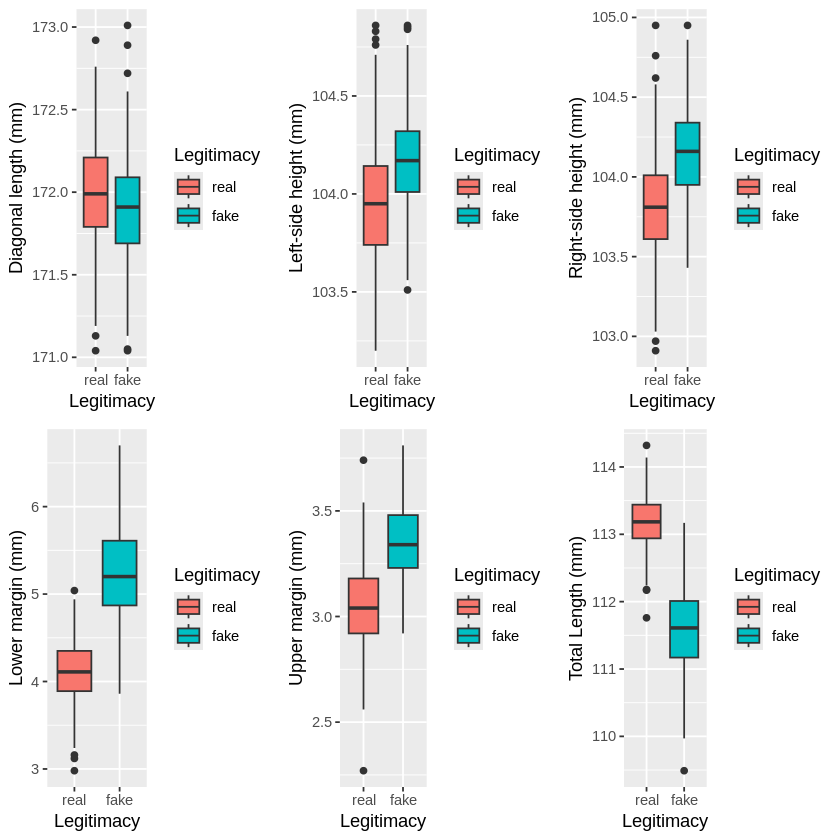

In [6]:
all_plots <- list()

# the legitimacy variable has been added as both the x-variable as well as the fill
# variable in order to encourage redundacy to make the plot more clear.

#boxplot for diagonal length
diag_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = diagonal, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Diagonal length (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(diag_plot))

#boxplot for left-side height
lsh_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = height_left, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Left-side height (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(lsh_plot))

#boxplot for right-side height
rsh_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = height_right, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Right-side height (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(rsh_plot))

#boxplot for lower margin
lower_margin_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = margin_low, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Lower margin (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(lower_margin_plot))

#boxplot for upper margin
upper_margin_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = margin_up, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Upper margin (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(upper_margin_plot))

#boxplot for total length
length_plot <- bills_training |>
        ggplot(aes(x = is_genuine, y = length, fill = is_genuine)) +
        geom_boxplot() +
        labs(x = "Legitimacy", y = "Total Length (mm)", fill = "Legitimacy")
all_plots <- c(all_plots, list(length_plot))

# arranging all plots in a grid with three columns
plot_grid(plotlist = all_plots, ncol = 3)

options(repr.plot.width = 12, repr.plot.height = 12)

In [7]:
# Select required columns
selected_bills_training_data = bills_training |>
                    select(is_genuine,height_left, height_right, margin_low,margin_up,length)


# Summary of training set
summary_bills_training_data <- bills_training |>
                    group_by(is_genuine) |>
                    summarize(mean_height_left = mean(height_left),
                             mean_height_right = mean(height_right),
                             mean_margin_low = mean(margin_low),
                             mean_margin_up = mean(margin_up),
                             mean_length = mean(length),
                             total_count=n())

summary_bills_training_data

is_genuine,mean_height_left,mean_height_right,mean_margin_low,mean_margin_up,mean_length,total_count
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
real,103.9481,103.8068,4.111882,3.048791,113.1845,728
fake,104.1748,104.1471,5.229864,3.349810,111.6137,369


In [8]:
bills_class <- bills_training |>
    group_by(is_genuine) |>
    summarize(count = n()) 
bills_class

is_genuine,count
<fct>,<int>
real,728
fake,369


In [9]:
fake_bills_recipe <- recipe(is_genuine ~ height_left + height_right + margin_low + margin_up,length, data = bills_training) |>
                step_upsample(is_genuine, over_ratio = 1, skip=FALSE) |>
                prep()

upsampled_bills_training <- bake(fake_bills_recipe, bills_training)

summary_bills_training_data_2 <- upsampled_bills_training |>
                    group_by(is_genuine) |>
                    summarize(total_count=n())

summary_bills_training_data_2

is_genuine,total_count
<fct>,<int>
real,728
fake,728


In [10]:
fake_bills_recipe_upsampled <- recipe(is_genuine ~ height_left + height_right + 
                                      margin_low + margin_up,length,
                                      data = upsampled_bills_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

In [12]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from=1,to=10,by=1))

bills_training_vfold <- vfold_cv(upsampled_bills_training, v=5,strata=is_genuine)

vfold_metrics <- workflow() |>
    add_recipe(fake_bills_recipe_upsampled) |>
    add_model(knn_spec) |>
    tune_grid(resamples=bills_training_vfold, grid=k_vals) |>
    collect_metrics()

accuracies <- vfold_metrics |> filter(.metric=="accuracy")

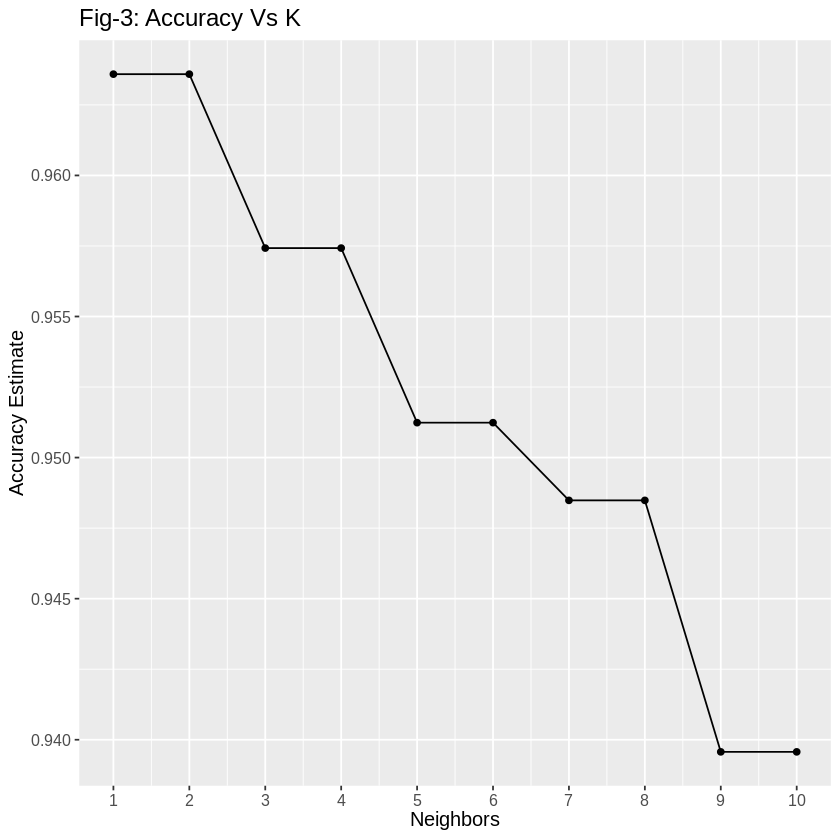

In [14]:
options(repr.plot.width=7,repr.plot.height=7)

accuracy_vs_k <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Neighbors", y="Accuracy Estimate") +
    scale_x_continuous(limits=c(1,10), breaks=1:10) +
    theme(text=element_text(size=12)) +
    ggtitle("Fig-3: Accuracy Vs K")
accuracy_vs_k

In [15]:
bills_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 2) |>
            set_engine("kknn") |>
            set_mode("classification")

#recreating the model with the new recipe
bills_fit <- workflow() |>
            add_recipe(fake_bills_recipe_upsampled) |>
            add_model(bills_spec) |>
            fit(data=bills_testing)


#predicting the results of wine_test data
bills_test_predictions <- predict(bills_fit, bills_testing) |>
                            bind_cols(bills_testing)

head(bills_test_predictions)

.pred_class,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
real,real,172.47,104.07,104.02,4.04,3.25,113.45
real,real,171.89,103.89,103.40,4.11,2.96,113.24
real,real,171.73,103.92,103.74,4.43,2.78,112.98
real,real,171.90,103.67,103.15,4.55,3.15,113.12
real,real,171.82,103.65,103.64,4.25,2.80,112.57
real,real,171.88,103.92,103.74,4.02,3.17,113.76


In [50]:
bills_test_predictions |> metrics(truth=is_genuine, estimate=.pred_class) |> filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,1
